# Logistic regression 5 folds breast

In [1]:
# LIBRARIES

import pandas as pd
import numpy as np
import io
import statistics as stat
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf


#  warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Confidence intervals
from sklearn.metrics import roc_auc_score
from math import sqrt

def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

In [3]:
# file upload 
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
end2end = pd.read_csv('/content/drive/MyDrive/COLAB/end2end191.csv')
frcnn = pd.read_csv('/content/drive/MyDrive/COLAB/frcnn191.csv')
glam = pd.read_csv('/content/drive/MyDrive/COLAB/glamn191.csv')
gmic = pd.read_csv('/content/drive/MyDrive/COLAB/gmicn191.csv')
nyu_single = pd.read_csv('/content/drive/MyDrive/COLAB/nyu_single191.csv')
# the gmicn and glamn files are loaded because they have the same order in the predictions as the other models 

Mounted at /content/drive


In [4]:
# Data information 
print("Images number")
print(len(glam['malignant_label']))
print("Patients number ")
print(len(glam['malignant_label'])/4)
print("Number of cancer patients ")
print(len(glam['malignant_label'])/8)
print("number of patients without cancer ")
print(len(glam['malignant_label'])/8)

Images number
1528
Patients number 
382.0
Number of cancer patients 
191.0
number of patients without cancer 
191.0


In [14]:
# Labels 
y_labels = glam['malignant_label'] 
# The model predictions are concatenated in X_predic
X_predic = pd.concat([end2end.loc[:, ['malignant_pred']], frcnn.loc[:, ['malignant_pred']], glam.loc[:, ['malignant_pred']], gmic.loc[:, ['malignant_pred']], nyu_single.loc[:, ['malignant_pred']]], axis=1)
# Each column is named according to the model
X_predic.columns = ['mal_pred_end2end', 'mal_pred_frcnn', 'mal_pred_glam', 'mal_pred_gmic', 'mal_pred_nyu_single']

In [15]:
# prediction calculation by breast
Y = y_labels.to_numpy()
X = X_predic.to_numpy()
Xb = np.zeros((764, 5))
Yb = np.zeros((764, 1))
np.array(Y, dtype=bool)

for i in  range(0,764,2):
     Xb[i,:] = (X[2*i,:]+ X[2*i+1,:])/2
     Xb[i+1,:] = (X[2*i+2,:]+ X[2*i+3,:])/2
      # Xp -> Breast predictions
     Yb[i] = ( Y[2*i] or Y[2*i+1]) 
     Yb[i+1,:] = ( Y[2*i+2] or Y[2*i+3]) 

X_predic_b = pd.DataFrame(Xb, columns = ['mal_pred_end2end', 'mal_pred_frcnn', 'mal_pred_glam', 'mal_pred_gmic', 'mal_pred_nyu_single'])
y_labels_b = pd.DataFrame(Yb, columns = ['malignant_label'])

In [16]:
# Folds creation 
# Each fold has 76 patients - 38 cases / 38 controls
# Fold 1 
X_fold1 = pd.concat([X_predic_b.iloc[0:76,:], X_predic_b.iloc[382:458,:]], axis=0)
Y_fold1 = pd.concat([y_labels_b.iloc[0:76], y_labels_b.iloc[382:458]], axis=0)
# Fold 2 
X_fold2 = pd.concat([X_predic_b.iloc[76:152,:], X_predic_b.iloc[458:534,:]], axis=0)
Y_fold2 = pd.concat([y_labels_b.iloc[76:152], y_labels_b.iloc[458:534]], axis=0)
# Fold 3  
X_fold3 = pd.concat([X_predic_b.iloc[152:228,:], X_predic_b.iloc[534:610,:]], axis=0)
Y_fold3 = pd.concat([y_labels_b.iloc[152:228], y_labels_b.iloc[534:610]], axis=0)
# Fold 4 
X_fold4 = pd.concat([X_predic_b.iloc[228:304,:], X_predic_b.iloc[610:686,:]], axis=0)
Y_fold4 = pd.concat([y_labels_b.iloc[228:304], y_labels_b.iloc[610:686]], axis=0)
# Fold 5 
X_fold5 = pd.concat([X_predic_b.iloc[304:382,:], X_predic_b.iloc[686:764,:]], axis=0)
Y_fold5 = pd.concat([y_labels_b.iloc[304:382], y_labels_b.iloc[686:764]], axis=0)

In [17]:
# fold 1 as test
# test
X_test1 = X_fold1
Y_test1 = Y_fold1
# train 
X_train1 = pd.concat([X_fold2,X_fold3,X_fold4,X_fold5], axis=0)
Y_train1 = pd.concat([Y_fold2,Y_fold3,Y_fold4,Y_fold5], axis=0)

# fold 2 as test
# test
X_test2 = X_fold2
Y_test2 = Y_fold2
# train 
X_train2 = pd.concat([X_fold1,X_fold3,X_fold4,X_fold5], axis=0)
Y_train2 = pd.concat([Y_fold1,Y_fold3,Y_fold4,Y_fold5], axis=0)

# fold 3 as test
# test
X_test3 = X_fold3
Y_test3 = Y_fold3
# train 
X_train3 = pd.concat([X_fold1,X_fold2,X_fold4,X_fold5], axis=0)
Y_train3 = pd.concat([Y_fold1,Y_fold2,Y_fold4,Y_fold5], axis=0)

# fold 4 as test
# test
X_test4 = X_fold4
Y_test4 = Y_fold4
# train 
X_train4 = pd.concat([X_fold1,X_fold2,X_fold3,X_fold5], axis=0)
Y_train4 = pd.concat([Y_fold1,Y_fold2,Y_fold3,Y_fold5], axis=0)

# fold 5 as test
# test
X_test5 = X_fold5
Y_test5 = Y_fold5
# train 
X_train5 = pd.concat([X_fold1,X_fold2,X_fold3,X_fold4], axis=0)
Y_train5 = pd.concat([Y_fold1,Y_fold2,Y_fold3,Y_fold4], axis=0)

Optimization terminated successfully.
         Current function value: 0.415562
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        malignant_label   No. Observations:                  612
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Jan 2023   Pseudo R-squ.:                  0.2610
Time:                        13:08:43   Log-Likelihood:                -254.32
converged:                       True   LL-Null:                       -344.15
Covariance Type:            nonrobust   LLR p-value:                 6.356e-37
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.5690      0.214    -12.006      0.000      -2.988      -2.150
ma

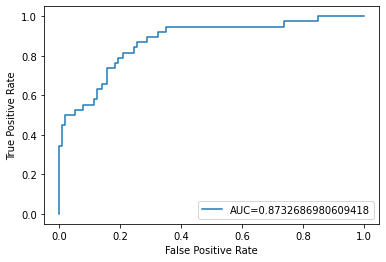

(0.797926343937719, 0.9486110521841645)

In [19]:
# Model creation FOLD 1
# ==============================================================================
# A column of ones is added to the predictor matrix for the intercept of the model.
X_train1 = sm.add_constant(X_train1, prepend=True)
model1 = sm.Logit(Y_train1,X_train1).fit()
print(model1.summary())

# Test the model1 with X_test1
X_test1 = sm.add_constant(X_test1, prepend=True)
Predictions1  = model1.predict(exog = X_test1)

#define metrics
fpr1, tpr1, _ = metrics.roc_curve(Y_test1,Predictions1)
auc1 = metrics.roc_auc_score(Y_test1,Predictions1)

#create ROC curve
plt.plot(fpr1,tpr1,label="AUC="+str(auc1))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
Y_test11 = Y_test1["malignant_label"]
Y_test11
roc_auc_ci(Y_test11, Predictions1)

Optimization terminated successfully.
         Current function value: 0.407219
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        malignant_label   No. Observations:                  612
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Jan 2023   Pseudo R-squ.:                  0.2758
Time:                        13:12:47   Log-Likelihood:                -249.22
converged:                       True   LL-Null:                       -344.15
Covariance Type:            nonrobust   LLR p-value:                 4.182e-39
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.6236      0.202    -12.969      0.000      -3.020      -2.227
ma

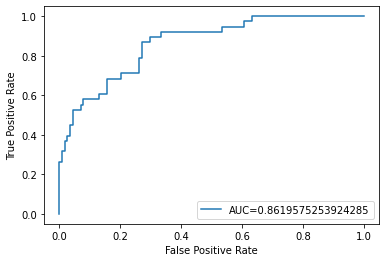

(0.783862725034449, 0.9400523257504081)

In [24]:
# Model creation FOLD 2
# ==============================================================================
# A column of ones is added to the predictor matrix for the intercept of the model.
X_train2 = sm.add_constant(X_train2, prepend=True)
model2 = sm.Logit(Y_train2,X_train2).fit()
print(model2.summary())

# Test the model2 with X_test2
X_test2 = sm.add_constant(X_test2, prepend=True)
Predictions2  = model2.predict(exog = X_test2)

#define metrics
fpr2, tpr2, _ = metrics.roc_curve(Y_test2,Predictions2)
auc2 = metrics.roc_auc_score(Y_test2,Predictions2)

#create ROC curve
plt.plot(fpr2,tpr2,label="AUC="+str(auc2))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
Y_test22 = Y_test2["malignant_label"]
Y_test22
roc_auc_ci(Y_test22, Predictions2)

Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        malignant_label   No. Observations:                  612
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Jan 2023   Pseudo R-squ.:                  0.2817
Time:                        13:12:58   Log-Likelihood:                -247.19
converged:                       True   LL-Null:                       -344.15
Covariance Type:            nonrobust   LLR p-value:                 5.650e-40
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.6522      0.209    -12.676      0.000      -3.062      -2.242
ma

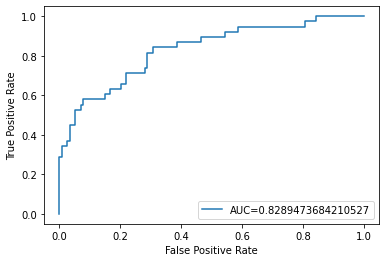

(0.7438280680388915, 0.9140666688032139)

In [25]:
# Model creation FOLD 3
# ==============================================================================
# A column of ones is added to the predictor matrix for the intercept of the model.
X_train3 = sm.add_constant(X_train3, prepend=True)
model3 = sm.Logit(Y_train3,X_train3).fit()
print(model3.summary())

# Test the model3 with X_test3
X_test3 = sm.add_constant(X_test3, prepend=True)
Predictions3  = model3.predict(exog = X_test3)

#define metrics
fpr3, tpr3, _ = metrics.roc_curve(Y_test3,Predictions3)
auc3 = metrics.roc_auc_score(Y_test3,Predictions3)

#create ROC curve
plt.plot(fpr3,tpr3,label="AUC="+str(auc3))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
Y_test33 = Y_test3["malignant_label"]
Y_test33
roc_auc_ci(Y_test33, Predictions3)

Optimization terminated successfully.
         Current function value: 0.402815
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        malignant_label   No. Observations:                  612
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Jan 2023   Pseudo R-squ.:                  0.2837
Time:                        13:13:14   Log-Likelihood:                -246.52
converged:                       True   LL-Null:                       -344.15
Covariance Type:            nonrobust   LLR p-value:                 2.943e-40
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.7381      0.211    -12.978      0.000      -3.152      -2.325
ma

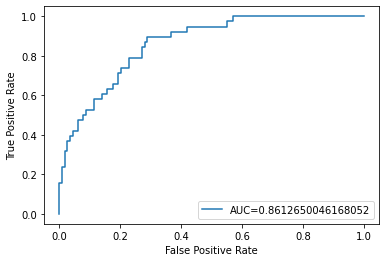

(0.7830079172979695, 0.939522091935641)

In [26]:
# Model creation FOLD 4
# ==============================================================================
# A column of ones is added to the predictor matrix for the intercept of the model.
X_train4 = sm.add_constant(X_train4, prepend=True)
model4 = sm.Logit(Y_train4,X_train4).fit()
print(model4.summary())

# Test the model4 with X_test4
X_test4 = sm.add_constant(X_test4, prepend=True)
Predictions4  = model4.predict(exog = X_test4)

#define metrics
fpr4, tpr4, _ = metrics.roc_curve(Y_test4,Predictions4)
auc4 = metrics.roc_auc_score(Y_test4,Predictions4)

#create ROC curve
plt.plot(fpr4,tpr4,label="AUC="+str(auc4))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
Y_test44 = Y_test4["malignant_label"]
Y_test44
roc_auc_ci(Y_test44, Predictions4)

Optimization terminated successfully.
         Current function value: 0.385487
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        malignant_label   No. Observations:                  608
Model:                          Logit   Df Residuals:                      602
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Jan 2023   Pseudo R-squ.:                  0.3145
Time:                        13:13:27   Log-Likelihood:                -234.38
converged:                       True   LL-Null:                       -341.90
Covariance Type:            nonrobust   LLR p-value:                 1.709e-44
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.7729      0.217    -12.761      0.000      -3.199      -2.347
ma

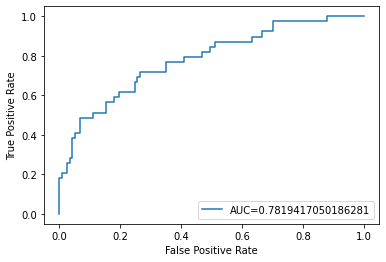

(0.6901416569030615, 0.8737417531341948)

In [27]:
# Model creation FOLD 5
# ==============================================================================
# A column of ones is added to the predictor matrix for the intercept of the model.
X_train5 = sm.add_constant(X_train5, prepend=True)
model5 = sm.Logit(Y_train5,X_train5).fit()
print(model5.summary())

# Test the model5 with X_test5
X_test5 = sm.add_constant(X_test5, prepend=True)
Predictions5  = model5.predict(exog = X_test5)

#define metrics
fpr5, tpr5, _ = metrics.roc_curve(Y_test5,Predictions5)
auc5 = metrics.roc_auc_score(Y_test5,Predictions5)

#create ROC curve
plt.plot(fpr5,tpr5,label="AUC="+str(auc5))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
Y_test55 = Y_test5["malignant_label"]
Y_test55
roc_auc_ci(Y_test55, Predictions5)

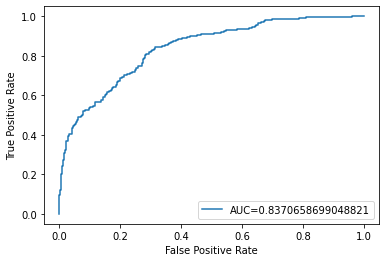

(0.7999178514153301, 0.874213888394434)

In [ ]:
# Total data 
Totalpred = pd.concat([Predictions1,Predictions2,Predictions3,Predictions4,Predictions5], axis=0)
Totalabels = pd.concat([Y_test1,Y_test2,Y_test3,Y_test4,Y_test5], axis=0)

#define metrics
fprT, tprT, _ = metrics.roc_curve(Totalabels,Totalpred)
aucT = metrics.roc_auc_score(Totalabels,Totalpred)

#create ROC curve
plt.plot(fprT,tprT,label="AUC="+str(aucT))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
roc_auc_ci(Totalabels.squeeze(),Totalpred)

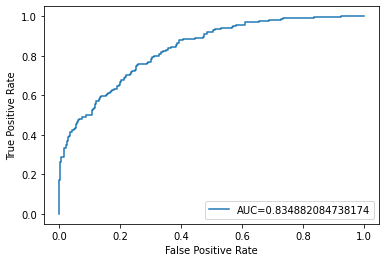

In [ ]:
# Total data + standardization 
predicciones_mean = Totalpred.mean()
predicciones_sd = Totalpred.std()
pred_est = (Totalpred - predicciones_mean) / predicciones_sd

#define metrics
fpre, tpre, _ = metrics.roc_curve(Totalabels,pred_est)
auce = metrics.roc_auc_score(Totalabels,pred_est)

#create ROC curve
plt.plot(fpre,tpre,label="AUC="+str(auce))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

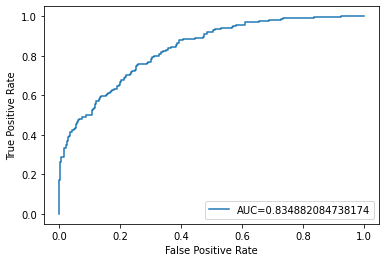

In [ ]:
# Total data + normalization 
def norm(df_input):
    return (Totalpred - Totalpred.min()) / ( Totalpred.max() - Totalpred.min())

pred_norm = norm(Totalpred)

#define metrics
fprn, tprn, _ = metrics.roc_curve(Totalabels,pred_norm)
aucn = metrics.roc_auc_score(Totalabels,pred_norm)

#create ROC curve
plt.plot(fprn,tprn,label="AUC="+str(aucn))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()